# How Does Piyush's Model Do as Classifier?

In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import uproot as ur
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/cephfs/user/cdimitri/ML4Pions/LCStudies/'
plotpath = '/cephfs/user/cdimitri/ML4Pions/classifier_output/Plots/'
modelpath = '/cephfs/user/cdimitri/ML4Pions/classifier_output/Models/'

In [3]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

In [4]:
inputpath = '/cephfs/user/cdimitri/ML4Pions/'
rootfiles = ["pi0_smol", "pi_charged_smol"]

trees, pdata = mu.setupPionData(inputpath, rootfiles)

np0 = len(pdata['pi0_smol'])
nppm = len(pdata['pi_charged_smol'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(nppm))

print("Total: {}".format(np0+nppm))

Number of pi0 events: 5055
Number of pi+ events: 8098
Total: 13153


In [5]:
pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer, flatten = False)
        for layer in mu.cell_meta
    }
    for ifile, itree in trees.items()
}

In [6]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow import keras as keras

In [7]:
import tensorflow as tf
NUM_THREADS=1
tf.config.threading.set_inter_op_parallelism_threads(NUM_THREADS)
tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
#gpu_list = ["/gpu:0","/gpu:1"]
#strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
# strategy = tf.distribute.MirroredStrategy()
#ngpu = strategy.num_replicas_in_sync
#print ('Number of devices: {}'.format(ngpu))

In [8]:
training_classes = ['pi0_smol','pi_charged_smol']
# create train/validation/test subsets containing 70%/10%/20%
# of events from each type of pion event
pdata_merged, pcells_merged, plabels = mu.createTrainingDatasets(training_classes, pdata, pcells)

In [9]:
pcellsE23_EMB2G_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (16, 16), layers=['EMB2', 'EMB3']),last=True)

In [10]:
pcellsE1_EMB1G_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (128, 4), layers=['EMB1']),last=True)

In [11]:
pcellsT123_T1G_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (4, 4), layers=['TileBar0', 'TileBar1', 'TileBar2']),last=True)

In [12]:
def merged_model(droprate=.5):
    #with strategy.scope():
    # EMB1 image (convolutional)
    input1 = Input(shape=(128,4,1), name='emb1_input')
    x1 = Convolution2D(32, (3, 3), padding='same', name='emb1_conv2d_1')(input1)
    x1 = Activation('relu')(x1)
    # x1 = Dropout(droprate)(x1)
    x1 = Convolution2D(32, (3, 3), padding='same', name='emb1_conv2d_2')(x1)
    x1 = Activation('relu')(x1)
    x1 = MaxPool2D(pool_size=(2, 1), padding='same', name='emb1_maxpool_3')(x1)
    x1 = Convolution2D(64, (3, 3), padding='same', name='emb1_conv2d_3')(x1)
    x1 = Activation('relu')(x1)
    #x1 = Dropout(droprate)(x1)
    x1 = Convolution2D(64, (3, 3), padding='same', name='emb1_conv2d_4')(x1)
    x1 = Activation('relu')(x1)
    x1 = MaxPool2D(pool_size=(2, 1), padding='same', name='emb1_maxpool_5')(x1)
    x1 = Convolution2D(128, (2, 2), padding='same', name='emb1_conv2d_6')(x1)
    x1 = Activation('relu')(x1)
    x1 = Convolution2D(128, (2, 2), padding='same', name='emb1_conv2d_7')(x1)
    x1 = Activation('relu')(x1)
    x1 = MaxPool2D(pool_size=(2, 1), padding='same', name='emb1_maxpool_8')(x1)
    x1 = Dropout(droprate, name='emb1_dropout_4')(x1)
    x1 = Flatten(name='emb1_flatten_9')(x1)
    x1 = Dense(128, activation='relu', name='emb1_dense_9')(x1)

    # EMB23 image (convolutional)
    input2 = Input(shape=(16,16,2), name='emb23_input')
    x2 = Convolution2D(32, (1, 1), padding='same', name='emb23_conv1d_1')(input2)
    x2 = Activation('relu')(x2)
    # x2 = Dropout(droprate)(x2)
    x2 = Convolution2D(64, (2, 2), padding='same', name='emb23_conv2d_2')(x2)
    # x2 = Dropout(droprate)(x2)
    x2 = MaxPool2D(pool_size=(2, 2), padding='same', name='emb23_maxpool_3')(x2)
    x2 = Convolution2D(128, (2, 2), padding='same', name='emb23_conv2d_4')(x2)
    x2 = Activation('relu')(x2)
    # x2 = Dropout(droprate)(x2)
    x2 = Convolution2D(128, (2, 2), padding='same', name='emb23_conv2d_5')(x2)
    x2 = Activation('relu')(x2)
    x2 = MaxPool2D(pool_size=(2, 2), padding='same', name='emb23_maxpool_6')(x2)
    x2 = Dropout(droprate, name='emb23_dropout_4')(x2)
    x2 = Flatten(name='emb23_flatten_7')(x2)
    x2 = Dense(128, activation='relu', name='emb23_dense_8')(x2)

    # tiles image (convolutional)
    input3 = Input(shape=(4,4,3), name='tiles_input')
    x3 = Convolution2D(32, (1, 1), padding='same', name='tiles_conv1d_1')(input3)
    x3 = Activation('relu')(x3)
    # x3 = Dropout(droprate)(x3)
    x3 = Convolution2D(64, (2, 2), padding='same', name='tiles_conv2d_2')(x3)
    x3 = Activation('relu')(x3)
    # x3 = Dropout(droprate)(x3)
    x3 = Convolution2D(128, (2, 2), padding='same', name='tiles_conv2d_3')(x3)
    x3 = Activation('relu')(x3)
    x3 = MaxPool2D(pool_size=(2, 2), padding='same', name='tiles_maxpool_4')(x3)
    x3 = Dropout(droprate, name='tiles_dropout_4')(x3)
    x3 = Flatten(name='tiles_flatten_5')(x3)
    x3 = Dense(128, activation='relu', name='tiles_dense_6')(x3)

    # concatenate outputs from the two networks above
    x = concatenate([x1, x2, x3], name='concatenate') 
    x = Dropout(droprate, name='concate_dropout_5')(x)
    x = Dense(64, name='concated_dense_1')(x)    
    x = Activation('relu')(x)
    x = Dropout(droprate, name='dense_dropout_6')(x)

    # final output
    output = Dense(2, activation='softmax', name='dense_output')(x)
    # output = 5*tf.math.tanh(x)   # 0 to +5 range

    model = Model(inputs = [input1, input2, input3], outputs = [output])

    # compile model
    # model = multi_gpu_model(model, gpus=4)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [13]:
model_p1_d02 = merged_model(0.2)

In [18]:
history_p1_d02 = model_p1_d02.fit([pcellsE1_EMB1G_channels[pdata_merged.train], 
                                pcellsE23_EMB2G_channels[pdata_merged.train], 
                                pcellsT123_T1G_channels[pdata_merged.train]],
                                plabels[pdata_merged.train],
                                validation_data=([pcellsE1_EMB1G_channels[pdata_merged.val], 
                                                    pcellsE23_EMB2G_channels[pdata_merged.val], 
                                                    pcellsT123_T1G_channels[pdata_merged.val]], 
                                                    plabels[pdata_merged.val]),
                                epochs=100,
                                batch_size = 128,
                                verbose=2
                                # use_multiprocessing=False
                                )

Epoch 1/100
72/72 - 70s - loss: 0.2651 - accuracy: 0.8732 - val_loss: 0.2807 - val_accuracy: 0.8762
Epoch 2/100
72/72 - 71s - loss: 0.2625 - accuracy: 0.8729 - val_loss: 0.2861 - val_accuracy: 0.8785
Epoch 3/100
72/72 - 71s - loss: 0.2628 - accuracy: 0.8763 - val_loss: 0.2870 - val_accuracy: 0.8778
Epoch 4/100
72/72 - 70s - loss: 0.2555 - accuracy: 0.8811 - val_loss: 0.2954 - val_accuracy: 0.8815
Epoch 5/100
72/72 - 70s - loss: 0.2516 - accuracy: 0.8852 - val_loss: 0.2995 - val_accuracy: 0.8838
Epoch 6/100
72/72 - 70s - loss: 0.2555 - accuracy: 0.8811 - val_loss: 0.2739 - val_accuracy: 0.8876
Epoch 7/100
72/72 - 70s - loss: 0.2492 - accuracy: 0.8816 - val_loss: 0.2924 - val_accuracy: 0.8914
Epoch 8/100
72/72 - 70s - loss: 0.2419 - accuracy: 0.8853 - val_loss: 0.2808 - val_accuracy: 0.8861
Epoch 9/100
72/72 - 71s - loss: 0.2443 - accuracy: 0.8811 - val_loss: 0.2808 - val_accuracy: 0.8861
Epoch 10/100
72/72 - 70s - loss: 0.2405 - accuracy: 0.8893 - val_loss: 0.2977 - val_accuracy: 0.8861

Epoch 83/100
72/72 - 71s - loss: 0.0648 - accuracy: 0.9756 - val_loss: 0.7511 - val_accuracy: 0.9271
Epoch 84/100
72/72 - 71s - loss: 0.0649 - accuracy: 0.9743 - val_loss: 0.7393 - val_accuracy: 0.9309
Epoch 85/100
72/72 - 71s - loss: 0.0760 - accuracy: 0.9707 - val_loss: 1.7475 - val_accuracy: 0.9210
Epoch 86/100
72/72 - 71s - loss: 0.0936 - accuracy: 0.9669 - val_loss: 0.9535 - val_accuracy: 0.9248
Epoch 87/100
72/72 - 71s - loss: 0.0597 - accuracy: 0.9762 - val_loss: 0.9249 - val_accuracy: 0.9286
Epoch 88/100
72/72 - 71s - loss: 0.0706 - accuracy: 0.9715 - val_loss: 0.8696 - val_accuracy: 0.9370
Epoch 89/100
72/72 - 70s - loss: 0.0625 - accuracy: 0.9752 - val_loss: 0.8189 - val_accuracy: 0.9317
Epoch 90/100
72/72 - 71s - loss: 0.0504 - accuracy: 0.9807 - val_loss: 0.8518 - val_accuracy: 0.9324
Epoch 91/100
72/72 - 71s - loss: 0.0467 - accuracy: 0.9822 - val_loss: 0.9423 - val_accuracy: 0.9355
Epoch 92/100
72/72 - 70s - loss: 0.0538 - accuracy: 0.9811 - val_loss: 1.0703 - val_accurac

<Figure size 799.992x599.976 with 0 Axes>

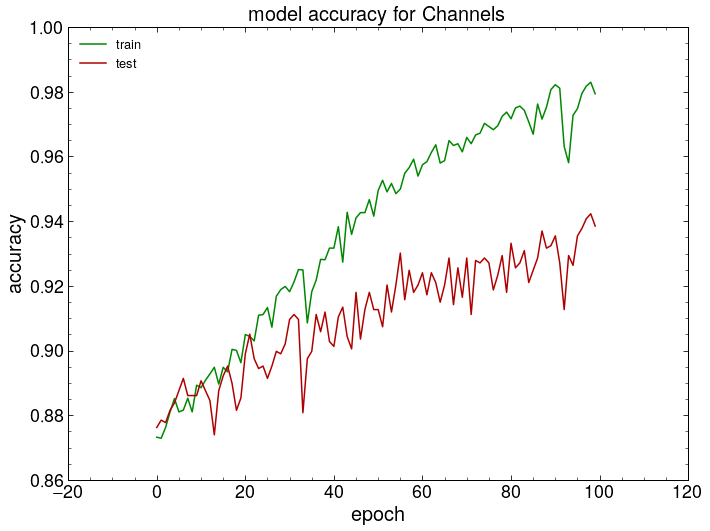

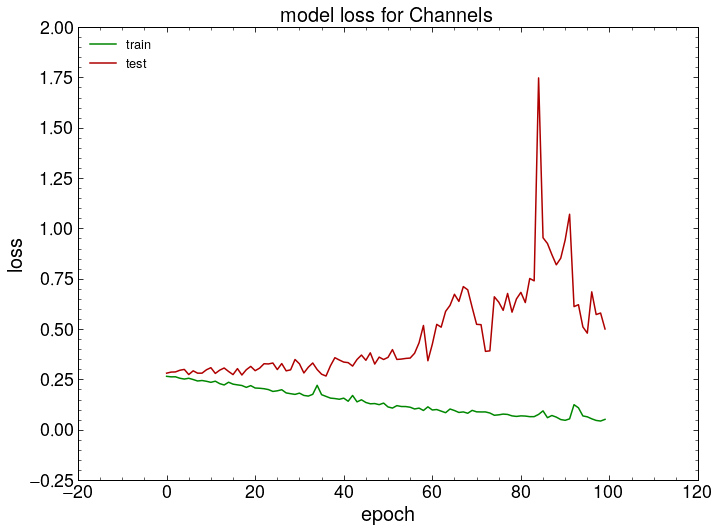

In [19]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_p1_d02.history['accuracy'])
plt.plot(history_p1_d02.history['val_accuracy'])
plt.title('model accuracy for Channels')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


    # summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_p1_d02.history['loss'])
plt.plot(history_p1_d02.history['val_loss'])
plt.title('model loss for Channels')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

In [21]:
model_p1_d02.save(modelpath+'model_p1_d02.h5')
scores_p1_d02 = model_p1_d02.predict([pcellsE1_EMB1G_channels, pcellsE23_EMB2G_channels, pcellsT123_T1G_channels])

In [22]:
model_p1_d02.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb1_input (InputLayer)         [(None, 128, 4, 1)]  0                                            
__________________________________________________________________________________________________
emb1_conv2d_1 (Conv2D)          (None, 128, 4, 32)   320         emb1_input[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 4, 32)   0           emb1_conv2d_1[0][0]              
__________________________________________________________________________________________________
emb1_conv2d_2 (Conv2D)          (None, 128, 4, 32)   9248        activation[0][0]                 
______________________________________________________________________________________________

In [20]:
from sklearn.metrics import roc_curve, auc
roc_fpr_p1_d02, roc_tpr_p1_d02, roc_thresh_p1_d02 = roc_curve(
        plabels[pdata_merged.test][:,1],
        scores_p1_d02[pdata_merged.test,1],
        drop_intermediate=False,
    )
roc_auc_p1_d02 = auc(roc_fpr_p1_d02, roc_tpr_p1_d02)
print('Area under curve for CNN p1_d02 ' + str(roc_auc_p1_d02))

Area under curve for CNN p1_d02 0.9898192961620463


## Best yet!!!

In [12]:
from util import densenet as dn

In [28]:
def dense_model(droprate=.5):
    with strategy.scope():
        # EMB1 image (convolutional)
        emb1_dense = dn.DenseNet(input_shape=(128,4,1), depth=13, 
                             nb_dense_block=1, growth_rate=16, dropout_rate=droprate,
                             include_top=False, model_prefix='emb1_')
        input1 = emb1_dense.input
        x1 =  emb1_dense.output
        x1 = Flatten(name='emb1_flatten')(x1)
        x1 = Dense(128, activation='relu', name='emb1_dense')(x1)

        # EMB23 image (convolutional)
        # input2 = Input(shape=(16,16,2), name='emb23_input')
        emb23_dense = dn.DenseNet(input_shape=(16,16,2), depth=13, 
                                nb_dense_block=1, growth_rate=16, dropout_rate=droprate,
                                include_top=False, model_prefix='emb23_')
        input2 = emb23_dense.input
        x2 =  emb23_dense.output
        x2 = Flatten(name='emb23_flatten')(x2)
        x2 = Dense(128, activation='relu', name='emb23_dense')(x2)

        # tiles image (convolutional)
        # input3 = Input(shape=(4,4,3), name='tiles_input')
        tiles_dense = dn.DenseNet(input_shape=(4,4,3), depth=13, 
                                nb_dense_block=1, growth_rate=16, dropout_rate=droprate,
                                include_top=False, model_prefix='tiles_')
        input3 = tiles_dense.input
        x3 =  tiles_dense.output
        x3 = Flatten(name='tiles_flatten')(x3)
        x3 = Dense(128, activation='relu', name='tiles_dense')(x3)

        # concatenate outputs from the two networks above
        x = concatenate([x1, x2, x3], name='concatenate') 
        x = Dropout(droprate, name='concate_dropout_5')(x)
        x = Dense(64, name='concated_dense_1')(x)    
        x = Activation('relu')(x)
        x = Dropout(droprate, name='dense_dropout_6')(x)

        # final output
        output = Dense(2, activation='softmax', name='dense_output')(x)
        # output = 5*tf.math.tanh(x)   # 0 to +5 range

        model = Model(inputs = [input1, input2, input3], outputs = [output])

        # compile model
        # model = multi_gpu_model(model, gpus=4)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

In [26]:
dense_05 = dense_model()
dense_05.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 128, 4, 1)]  0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 16, 16, 2)]  0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 4, 4, 3)]    0                                            
__________

In [27]:
history_dense_05 = dense_05.fit([pcellsE1_EMB1G_channels[pdata_merged.train], 
                                pcellsE23_EMB2G_channels[pdata_merged.train], 
                                pcellsT123_T1G_channels[pdata_merged.train]],
                                plabels[pdata_merged.train],
                                validation_data=([pcellsE1_EMB1G_channels[pdata_merged.val], 
                                                    pcellsE23_EMB2G_channels[pdata_merged.val], 
                                                    pcellsT123_T1G_channels[pdata_merged.val]], 
                                                    plabels[pdata_merged.val]),
                                epochs=250,
                                batch_size = 128*ngpu,
                                verbose=2
                                # use_multiprocessing=False
                                )

cy: 0.9537
Epoch 69/250
489899/489899 - 46s - loss: 0.1153 - accuracy: 0.9590 - val_loss: 0.1478 - val_accuracy: 0.9538
Epoch 70/250
489899/489899 - 46s - loss: 0.1150 - accuracy: 0.9589 - val_loss: 0.1481 - val_accuracy: 0.9538
Epoch 71/250
489899/489899 - 46s - loss: 0.1144 - accuracy: 0.9592 - val_loss: 0.1493 - val_accuracy: 0.9543
Epoch 72/250
489899/489899 - 46s - loss: 0.1141 - accuracy: 0.9594 - val_loss: 0.1455 - val_accuracy: 0.9548
Epoch 73/250
489899/489899 - 46s - loss: 0.1139 - accuracy: 0.9593 - val_loss: 0.1474 - val_accuracy: 0.9541
Epoch 74/250
489899/489899 - 46s - loss: 0.1134 - accuracy: 0.9593 - val_loss: 0.1467 - val_accuracy: 0.9539
Epoch 75/250
489899/489899 - 46s - loss: 0.1126 - accuracy: 0.9600 - val_loss: 0.1487 - val_accuracy: 0.9545
Epoch 76/250
489899/489899 - 46s - loss: 0.1126 - accuracy: 0.9598 - val_loss: 0.1486 - val_accuracy: 0.9549
Epoch 77/250
489899/489899 - 46s - loss: 0.1117 - accuracy: 0.9600 - val_loss: 0.1474 - val_accuracy: 0.9548
Epoch 78

<Figure size 576x432 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


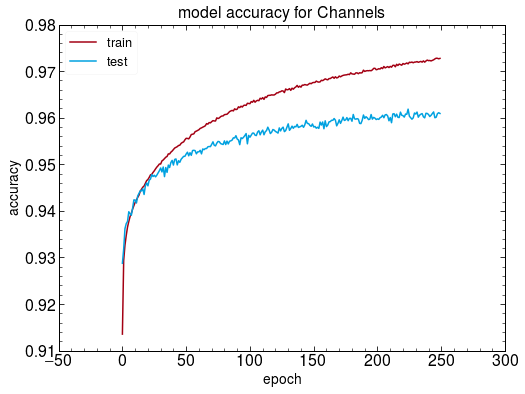

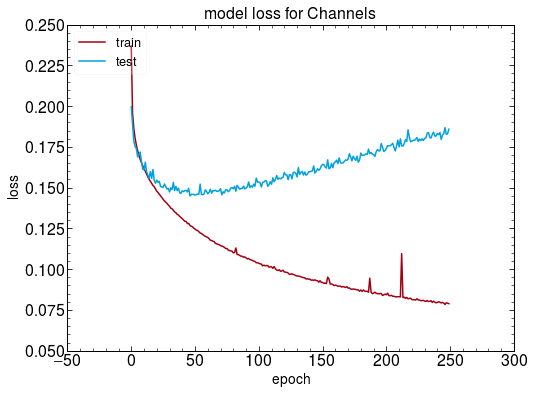

In [28]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_dense_05.history['accuracy'])
plt.plot(history_dense_05.history['val_accuracy'])
plt.title('model accuracy for Channels')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


    # summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_dense_05.history['loss'])
plt.plot(history_dense_05.history['val_loss'])
plt.title('model loss for Channels')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

In [30]:
dense_05.save(modelpath+'model_dense_05.h5')
scores_dense_05 = dense_05.predict([pcellsE1_EMB1G_channels, pcellsE23_EMB2G_channels, pcellsT123_T1G_channels])

In [31]:
from sklearn.metrics import roc_curve, auc
roc_fpr_dense_05, roc_tpr_dense_05, roc_thresh_dense_05 = roc_curve(
        plabels[pdata_merged.test][:,1],
        scores_dense_05[pdata_merged.test,1],
        drop_intermediate=False,
    )
roc_auc_dense_05 = auc(roc_fpr_dense_05, roc_tpr_dense_05)
print('Area under curve for dense_05 ' + str(roc_auc_dense_05))

Area under curve for dense_05 0.9883793733918668


## Densenet not necessarily better!

Points of concern:

* over training?
* too many epochs?
* how to choose...

Should compare in other metrics now, like ROC curves?

In [17]:
dense_05_e40 = dense_model()
dense_05_e40.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 4, 1)]  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 16, 16, 2)]  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 4, 4, 3)]    0                                            
__________

In [18]:
history_dense_05_e40 = dense_05_e40.fit([pcellsE1_EMB1G_channels[pdata_merged.train], 
                                pcellsE23_EMB2G_channels[pdata_merged.train], 
                                pcellsT123_T1G_channels[pdata_merged.train]],
                                plabels[pdata_merged.train],
                                validation_data=([pcellsE1_EMB1G_channels[pdata_merged.val], 
                                                    pcellsE23_EMB2G_channels[pdata_merged.val], 
                                                    pcellsT123_T1G_channels[pdata_merged.val]], 
                                                    plabels[pdata_merged.val]),
                                epochs=40,
                                batch_size = 128*ngpu,
                                verbose=2
                                # use_multiprocessing=False
                                )

Train on 489899 samples, validate on 69988 samples
Epoch 1/40
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 the

In [19]:
dense_05_e40.save(modelpath+'model_dense_05_e40.h5')
scores_dense_05_e40 = dense_05_e40.predict([pcellsE1_EMB1G_channels, pcellsE23_EMB2G_channels, pcellsT123_T1G_channels])

In [20]:
from sklearn.metrics import roc_curve, auc
roc_fpr_dense_05_e40, roc_tpr_dense_05_e40, roc_thresh_dense_05_e40 = roc_curve(
        plabels[pdata_merged.test][:,1],
        scores_dense_05_e40[pdata_merged.test,1],
        drop_intermediate=False,
    )
roc_auc_dense_05_e40 = auc(roc_fpr_dense_05_e40, roc_tpr_dense_05_e40)
print('Area under curve for dense_05_e40 ' + str(roc_auc_dense_05_e40))

Area under curve for dense_05_e40 0.9863544215487565


Ok, with less epochs it does even worse. Interesting.

## Try merged model with dropout 0.5

In [22]:
model_p1_d05 = merged_model(0.5)
history_p1_d05 = model_p1_d05.fit([pcellsE1_EMB1G_channels[pdata_merged.train], 
                                pcellsE23_EMB2G_channels[pdata_merged.train], 
                                pcellsT123_T1G_channels[pdata_merged.train]],
                                plabels[pdata_merged.train],
                                validation_data=([pcellsE1_EMB1G_channels[pdata_merged.val], 
                                                    pcellsE23_EMB2G_channels[pdata_merged.val], 
                                                    pcellsT123_T1G_channels[pdata_merged.val]], 
                                                    plabels[pdata_merged.val]),
                                epochs=250,
                                batch_size = 128*ngpu,
                                verbose=2
                                # use_multiprocessing=False
                                )

cy: 0.9453
Epoch 69/250
489899/489899 - 35s - loss: 0.1511 - accuracy: 0.9467 - val_loss: 0.1547 - val_accuracy: 0.9455
Epoch 70/250
489899/489899 - 35s - loss: 0.1508 - accuracy: 0.9468 - val_loss: 0.1530 - val_accuracy: 0.9461
Epoch 71/250
489899/489899 - 35s - loss: 0.1510 - accuracy: 0.9467 - val_loss: 0.1494 - val_accuracy: 0.9467
Epoch 72/250
489899/489899 - 35s - loss: 0.1491 - accuracy: 0.9474 - val_loss: 0.1528 - val_accuracy: 0.9463
Epoch 73/250
489899/489899 - 35s - loss: 0.1517 - accuracy: 0.9468 - val_loss: 0.1527 - val_accuracy: 0.9468
Epoch 74/250
489899/489899 - 35s - loss: 0.1494 - accuracy: 0.9475 - val_loss: 0.1520 - val_accuracy: 0.9466
Epoch 75/250
489899/489899 - 35s - loss: 0.1485 - accuracy: 0.9478 - val_loss: 0.1533 - val_accuracy: 0.9468
Epoch 76/250
489899/489899 - 35s - loss: 0.1546 - accuracy: 0.9453 - val_loss: 0.1596 - val_accuracy: 0.9426
Epoch 77/250
489899/489899 - 35s - loss: 0.1551 - accuracy: 0.9449 - val_loss: 0.1513 - val_accuracy: 0.9470
Epoch 78

In [23]:
model_p1_d05.save(modelpath+'model_p1_d05.h5')
scores_p1_d05 = model_p1_d05.predict([pcellsE1_EMB1G_channels, pcellsE23_EMB2G_channels, pcellsT123_T1G_channels])

In [25]:
from sklearn.metrics import roc_curve, auc
roc_fpr_p1_d05, roc_tpr_p1_d05, roc_thresh_p1_d05 = roc_curve(
        plabels[pdata_merged.test][:,1],
        scores_p1_d05[pdata_merged.test,1],
        drop_intermediate=False,
    )
roc_auc_p1_d05 = auc(roc_fpr_p1_d05, roc_tpr_p1_d05)
print('Area under curve for p1_d05 ' + str(roc_auc_p1_d05))

Area under curve for p1_d05 0.9864951816521064


Worse! so try densenet with just 0.2....?


In [29]:
dense_02 = dense_model(0.2)
dense_02.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128, 4, 1)]  0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 16, 16, 2)]  0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 4, 4, 3)]    0                                            
__________________________________________________________________________________________________
emb1_initial_conv2D (Conv2D)    (None, 128, 4, 32)   128         input_10[0][0]                   
____________________________________________________________________________________________

In [30]:
history_dense_02 = dense_02.fit([pcellsE1_EMB1G_channels[pdata_merged.train], 
                                pcellsE23_EMB2G_channels[pdata_merged.train], 
                                pcellsT123_T1G_channels[pdata_merged.train]],
                                plabels[pdata_merged.train],
                                validation_data=([pcellsE1_EMB1G_channels[pdata_merged.val], 
                                                    pcellsE23_EMB2G_channels[pdata_merged.val], 
                                                    pcellsT123_T1G_channels[pdata_merged.val]], 
                                                    plabels[pdata_merged.val]),
                                epochs=250,
                                batch_size = 128*ngpu,
                                verbose=2
                                # use_multiprocessing=False
                                )

cy: 0.9531
Epoch 69/250
489899/489899 - 47s - loss: 0.1320 - accuracy: 0.9527 - val_loss: 0.1426 - val_accuracy: 0.9518
Epoch 70/250
489899/489899 - 47s - loss: 0.1321 - accuracy: 0.9525 - val_loss: 0.1420 - val_accuracy: 0.9523
Epoch 71/250
489899/489899 - 47s - loss: 0.1322 - accuracy: 0.9530 - val_loss: 0.1426 - val_accuracy: 0.9526
Epoch 72/250
489899/489899 - 47s - loss: 0.1319 - accuracy: 0.9530 - val_loss: 0.1422 - val_accuracy: 0.9523
Epoch 73/250
489899/489899 - 47s - loss: 0.1309 - accuracy: 0.9533 - val_loss: 0.1424 - val_accuracy: 0.9519
Epoch 74/250
489899/489899 - 47s - loss: 0.1306 - accuracy: 0.9533 - val_loss: 0.1412 - val_accuracy: 0.9529
Epoch 75/250
489899/489899 - 47s - loss: 0.1302 - accuracy: 0.9533 - val_loss: 0.1415 - val_accuracy: 0.9523
Epoch 76/250
489899/489899 - 47s - loss: 0.1305 - accuracy: 0.9536 - val_loss: 0.1414 - val_accuracy: 0.9526
Epoch 77/250
489899/489899 - 47s - loss: 0.1306 - accuracy: 0.9536 - val_loss: 0.1411 - val_accuracy: 0.9526
Epoch 78

Just noticed droputout was commented out. so existing Dense was w/o dropout. Try 0.2 first then.

In [31]:
dense_02.save(modelpath+'model_dense_02.h5')
scores_dense_02 = dense_02.predict([pcellsE1_EMB1G_channels, pcellsE23_EMB2G_channels, pcellsT123_T1G_channels])

In [32]:
from sklearn.metrics import roc_curve, auc
roc_fpr_dense_02, roc_tpr_dense_02, roc_thresh_dense_02 = roc_curve(
        plabels[pdata_merged.test][:,1],
        scores_dense_02[pdata_merged.test,1],
        drop_intermediate=False,
    )
roc_auc_dense_02 = auc(roc_fpr_dense_02, roc_tpr_dense_02)
print('Area under curve for dense_02 ' + str(roc_auc_dense_02))

Area under curve for dense_02 0.9893953176301126


<Figure size 576x432 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


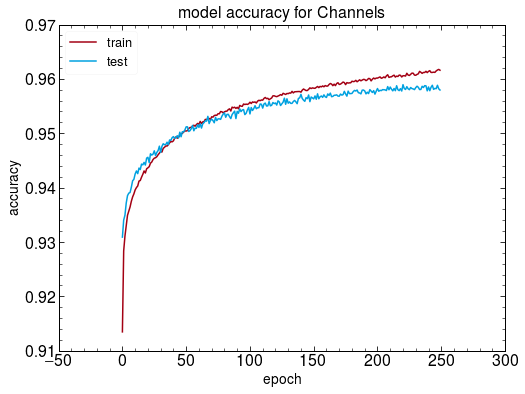

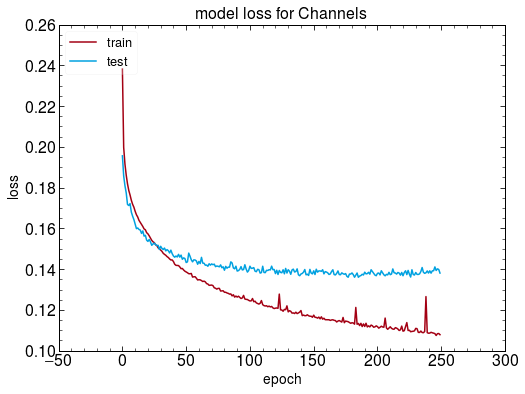

In [33]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_dense_02.history['accuracy'])
plt.plot(history_dense_02.history['val_accuracy'])
plt.title('model accuracy for Channels')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


    # summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_dense_02.history['loss'])
plt.plot(history_dense_02.history['val_loss'])
plt.title('model loss for Channels')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

still a little worse than piyushnet, but getting up there!